In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import h5py
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
import random

In [2]:
f=h5py.File(r'features_database_gait_one_cycles_both_legs.h5', 'r')
print(list(f.keys()))
x = f['right'][:,:,:]
print('(samples, timesteps, features)', x.shape)

['left', 'right']
(samples, timesteps, features) (74, 132, 7)


In [3]:
path = f'cut_one_gait_cycle_right'
filelist =[]
digits =[]
digits_int =[]
for file in glob.glob(f'{path}\\*.c3d',recursive = True):
    filelist.append(file[4:-4].replace("_", ""))
    digits.append(file[25:-9])

for ele in digits:
    digits_int.append(1) if ele=='degeneration' else digits_int.append(0)

In [4]:
nsamples, nx, ny = x.shape
d2_x = x.reshape((nsamples,nx*ny))

In [5]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(d2_x)
scaled_data

array([[-0.92125674, -0.6165565 , -0.69867153, ...,  0.1108021 ,
        -1.26665914, -0.17671998],
       [-1.29455354, -0.3242606 , -0.44893282, ..., -0.206346  ,
        -0.59028727, -1.36097123],
       [-0.85459138, -0.60811885, -0.7751116 , ..., -0.34795983,
         0.28792832, -0.34046659],
       ...,
       [ 1.03513362, -0.76945603, -1.2987694 , ...,  0.65662284,
         1.00996164,  0.90237715],
       [ 1.908187  , -0.90759249, -0.6421859 , ...,  0.61504368,
        -0.57523387, -1.39050083],
       [ 1.03513362, -0.76945603, -1.2987694 , ...,  0.65662284,
         1.00996164,  0.90237715]])

In [6]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(scaled_data, digits_int, test_size = 0.2, random_state = 0) 

In [7]:
sc = StandardScaler()   
X_train = sc.fit_transform(X_train) 
X_test = sc.transform(X_test) 

In [8]:
mean_vec=np.mean(X_train,axis=0)
cov_mat=(X_train-mean_vec).T.dot((X_train-mean_vec))/(X_train.shape[0]-1)
mean_vect=np.mean(X_test,axis=0)
cov_matt=(X_test-mean_vec).T.dot((X_test-mean_vec))/(X_test.shape[0]-1)
print(cov_mat)

[[ 1.01724138 -0.3857106   0.26427415 ... -0.06734912  0.3026581
   0.35408563]
 [-0.3857106   1.01724138 -0.10337543 ... -0.05685625 -0.21009133
  -0.22020097]
 [ 0.26427415 -0.10337543  1.01724138 ...  0.21703242  0.09466017
   0.07629419]
 ...
 [-0.06734912 -0.05685625  0.21703242 ...  1.01724138  0.17964073
   0.08165587]
 [ 0.3026581  -0.21009133  0.09466017 ...  0.17964073  1.01724138
   0.69784972]
 [ 0.35408563 -0.22020097  0.07629419 ...  0.08165587  0.69784972
   1.01724138]]


In [9]:
cov_mat=np.cov(X_train.T)
eig_vals,eig_vecs=np.linalg.eig(cov_mat)
cov_matt=np.cov(X_test.T)
eig_vals,eig_vecs=np.linalg.eig(cov_mat)

In [10]:
from sklearn.decomposition import PCA 
components = min(74, 7)
pca = PCA(n_components=components, svd_solver='full')
X_train = pca.fit_transform(X_train) 
X_test = pca.transform(X_test) 
X_train.shape

(59, 7)

In [11]:
from sklearn.tree import DecisionTreeClassifier   
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

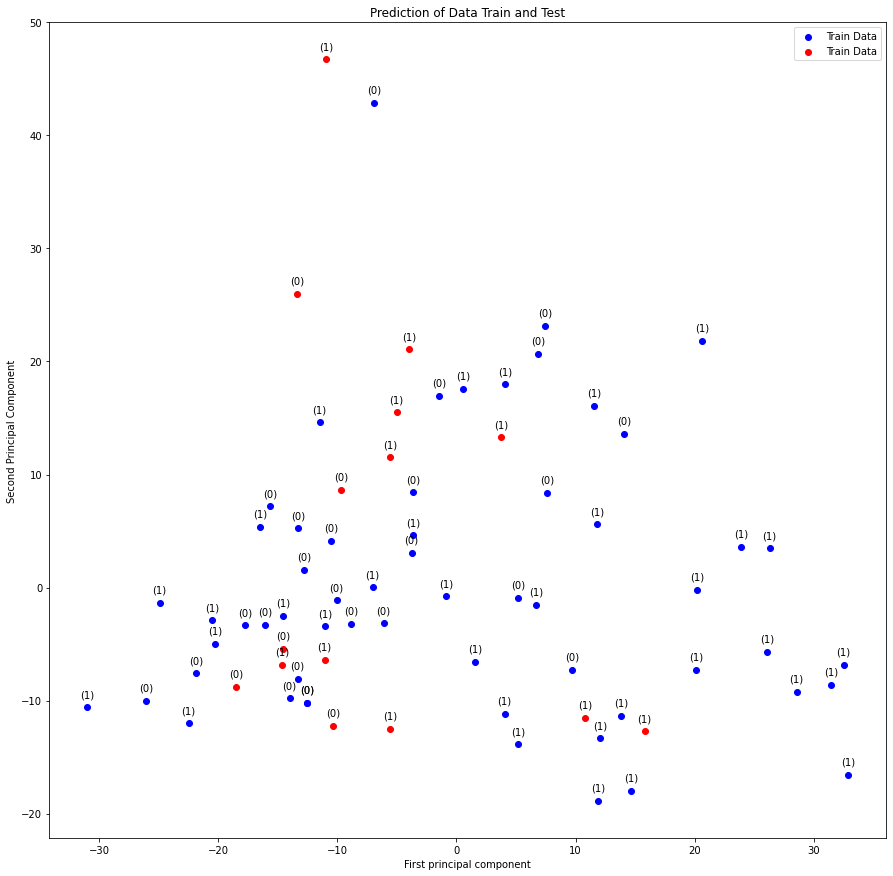

In [12]:
plt.figure(figsize=(15,15))
plt.scatter(X_train[:,0],X_train[:,1], c='blue', label='Train Data')
for x,y,z in zip(X_train[:,0],X_train[:,1], y_pred_train):
    label = f"({z})"
    plt.annotate(label, 
                 (x,y), 
                 textcoords="offset points", 
                 xytext=(0,10),
                 ha='center')
plt.scatter(X_test[:,0],X_test[:,1], c='red', label='Train Data')
for x,y,z in zip(X_test[:,0],X_test[:,1], y_pred_test):
    label = f"({z})"
    plt.annotate(label, 
                 (x,y), 
                 textcoords="offset points", 
                 xytext=(0,10),
                 ha='center')
    
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.title('Prediction of Data Train and Test')
plt.legend()

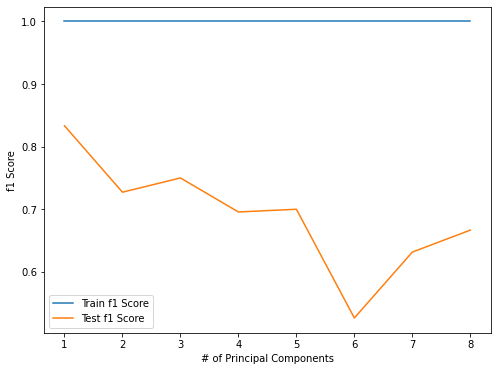

In [22]:
from sklearn.metrics import f1_score, classification_report, plot_confusion_matrix
train_f1 = []
test_f1 = []

for i in range(8):
    
    X = scaled_data[:,0:i+1]
    
    # Train-test-split
    X_train, X_test, y_train, y_test = train_test_split(X, digits_int,
                                                        test_size=0.25,
                                                        random_state=42)

    # Perform feature scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Fit k-NN classifier and make predictions
    dtc = DecisionTreeClassifier()
    dtc.fit(X_train, y_train)
    y_pred_train = dtc.predict(X_train)
    y_pred_test = dtc.predict(X_test)
    train_f1.append(f1_score(y_train, y_pred_train))
    test_f1.append(f1_score(y_test, y_pred_test))

# Plot accuracy by n_neighbors
plt.figure(figsize=(8, 6))
plt.plot(range(1,9), train_f1, label='Train f1 Score')
plt.plot(range(1,9), test_f1, label='Test f1 Score')
plt.ylabel('f1 Score')
plt.xlabel('# of Principal Components')
plt.legend()
plt.show()

In [19]:
X = scaled_data[:,0:7]
    
# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, digits_int,
                                                    test_size=0.25,
                                                    random_state=42)

# Perform feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred_train = dtc.predict(X_train)
y_pred_test = dtc.predict(X_test)
    
print(f'Train f1 Score: {f1_score(y_train, y_pred_train)}')
print(f'Test f1 Score: {f1_score(y_test, y_pred_test)}')
print(classification_report(y_test, y_pred_test))

Train f1 Score: 1.0
Test f1 Score: 0.6086956521739131
              precision    recall  f1-score   support

           0       0.38      0.43      0.40         7
           1       0.64      0.58      0.61        12

    accuracy                           0.53        19
   macro avg       0.51      0.51      0.50        19
weighted avg       0.54      0.53      0.53        19



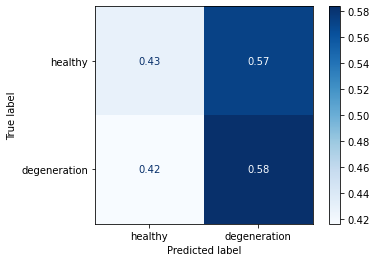

In [20]:
plot_confusion_matrix(dtc, X_test, y_test, display_labels=['healthy','degeneration'],
                      normalize='true', cmap='Blues');